In [1]:
import cv2
from PIL import Image, ImageOps
import argparse
import os
import glob
import matplotlib.pyplot as plt
import multiprocessing as mp
from joblib import Parallel, delayed
import pydicom
import time
import numpy as np
import torch
import random
import pandas as pd
from pydicom.pixel_data_handlers import apply_windowing
import imageio
import time
import shutil

In [2]:
from AlexNet import *

1.13.1+cu116


In [3]:
model = AlexNet(num_classes=52)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.000000001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

model.load_state_dict(torch.load('card_best.pth'))


<All keys matched successfully>

In [4]:
test_transforms = transforms.Compose([
                                       transforms.Resize((256, 256)),
                                       transforms.RandomCrop((224, 224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))
                                      ])

In [5]:

rev_dict={0: 'ace of spades', 1: 'two of spades', 2: 'three of spades', 3: 'four of spades', 4: 'five of spades', 5: 'six of spades', 6: 'seven of spades',
      7: 'eight of spades', 8: 'nine of spades', 9: 'ten of spades', 10: 'jack of spades', 11: 'queen of spades', 12: 'king of spades',
      13: 'ace of hearts', 14: 'two of hearts', 15: 'three of hearts', 16: 'four of hearts', 17: 'five of hearts', 18: 'six of hearts',
      19: 'seven of hearts', 20: 'eight of hearts', 21: 'nine of hearts', 22: 'ten of hearts', 23: 'jack of hearts', 24: 'queen of hearts',
      25: 'king of hearts',
      26: 'ace of clubs', 27: 'two of clubs', 28: 'three of clubs', 29: 'four of clubs', 30: 'five of clubs', 31: 'six of clubs',
      32: 'seven of clubs', 33: 'eight of clubs', 34: 'nine of clubs', 35: 'ten of clubs', 36: 'jack of clubs', 37: 'queen of clubs',
      38: 'king of clubs',
      39: 'ace of diamonds', 40: 'two of diamonds', 41: 'three of diamonds', 42: 'four of diamonds', 43: 'five of diamonds', 44: 'six of diamonds',
      45: 'seven of diamonds', 46: 'eight of diamonds', 47: 'nine of diamonds', 48: 'ten of diamonds', 49: 'jack of diamonds', 50: 'queen of diamonds',
      51: 'king of diamonds'
           
}

In [6]:
# Đọc bức ảnh vào và tách các lá bài
image = cv2.imread(r"E:\Lam_thue\card\test_final.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresholded = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
contours, hierarchy = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
imageio.imwrite(f'gray.png', thresholded)

In [7]:
len(contours)

133

tensor([51], device='cuda:0')
tensor([36], device='cuda:0')
tensor([40], device='cuda:0')


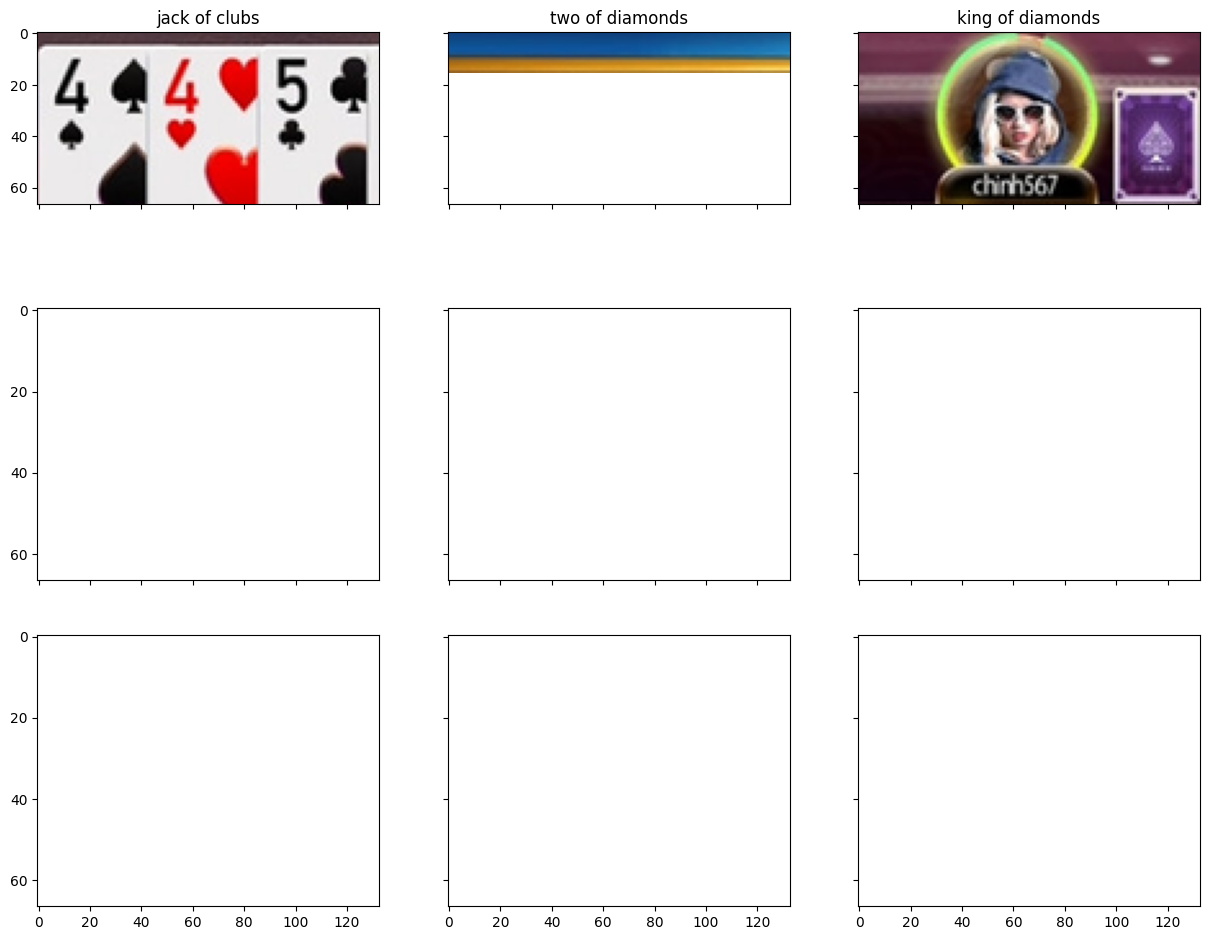

In [16]:
id = 1
fig, axes = plt.subplots(nrows=3, ncols=3,
                          sharex=True, sharey=True, figsize=(15,12
                                                             ))
axes = axes.flatten()      
id = 0

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    img = image[y:y+h, x:x+w]
    img_gray = thresholded[y:y+h, x:x+w]
    if np.sum(img_gray/255) <1000: continue
    
    
    img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))   
    with torch.no_grad():
        features = test_transforms(img).cuda()
        batch_size = 1
        features = features.unsqueeze(0).expand(batch_size, -1, -1, -1) 
        logits = model(features)
        print(predictions)
        predictions =  torch.unique(torch.argmax(logits, dim=1))
        so_luong_pixel = 0
        id_final = 0
        '''
        Lấy label có có số pixel nhỏ nhất khi trừ ảnh tiêu chuẩn
        '''
        for i in predictions:
            f, p = rev_dict[i.item()].split(' of ')
            img_std = cv2.imread(f'data/{p}/{f}.png')
            img_std = cv2.cvtColor(img_std, cv2.COLOR_BGR2GRAY)
            img_std = cv2.resize(img_std, (img_gray.shape[1], img_gray.shape[0]))
            img_total = img_std - img_gray
            img_total[img_total < 0] = 0
            if np.sum(img_total) <= so_luong_pixel or id_final == 0 :
                id_final = i.item()
                so_luong_pixel = np.sum(img_std - img_gray)
        axes[id].imshow(img)
        axes[id].set_title(f'{rev_dict[id_final]}')
        id+=1